In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'KMM_weighted_kernel_sufficient_dimension_reduction_gradient'
seed = 44

In [2]:
import autograd.numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/KMM_weighted_kernel_sufficient_dimension_reduction_gradient'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats, scipy
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint, autograd

Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
# specify dimension of X,Z
x_dim = 2
u_dim = 1
y_dim = 1 # code will assume this

In [5]:
# define train distribution
train_mean = np.zeros(shape=x_dim)
p_x_train_dist = scipy.stats.multivariate_normal(mean=train_mean)
p_x_train_pdf = p_x_train_dist.pdf
p_x_train_sample = p_x_train_dist.rvs

In [6]:
# define test distribution
test_mean = np.zeros(x_dim)+1
#test_mean[0] = 1.
p_x_test_dist = scipy.stats.multivariate_normal(mean=test_mean)
p_x_test_pdf = p_x_test_dist.pdf
p_x_test_sample = p_x_test_dist.rvs

In [7]:
# specify y|x

# P
#P = kernels.ortho(np.array([[1.,2.]]).T)
P = kernels.ortho(np.random.normal(size=(x_dim,u_dim)))
print 'P:', P

# p_y_given_z
f_u = lambda u: 1*np.ones(u_dim).dot(u)
y_var = 0.002
p_y_noise_sample = scipy.stats.multivariate_normal(mean=np.zeros(shape=y_dim),cov=np.eye(y_dim)*y_var).rvs
#p_y_given_z_pdf = lambda y,z: p_y_noise.pdf(y-z)
p_y_given_u_sample = lambda u: f_u(u) + p_y_noise_sample()
#p_y_given_z_sample = lambda z: z
def mix():
    if np.random.uniform()>0.3:
        return scipy.stats.multivariate_normal(mean=np.ones(shape=y_dim)*10.,cov=np.eye(y_dim)*y_var).rvs()
    else:
        return scipy.stats.multivariate_normal(mean=np.ones(shape=y_dim)*-10.,cov=np.eye(y_dim)*y_var).rvs()
#p_y_given_z_sample = lambda z: f_z(z) + mix()

P: [[-0.495348  ]
 [ 0.86869463]]


In [8]:
# specify number of data to generate
num_train = 10
num_test = 15

In [9]:
# generate data
np.random.seed(42)
xs_train = np.array([p_x_train_sample() for i in xrange(num_train)])
xs_test = np.array([p_x_test_sample() for i in xrange(num_test)])
print xs_test
us_train = xs_train.dot(P)
ys_train = np.array([p_y_given_u_sample(u) for u in us_train])

[[ 2.46564877  0.7742237 ]
 [ 1.0675282  -0.42474819]
 [ 0.45561728  1.11092259]
 [-0.15099358  1.37569802]
 [ 0.39936131  0.70830625]
 [ 0.39829339  2.85227818]
 [ 0.98650278 -0.05771093]
 [ 1.82254491 -0.22084365]
 [ 1.2088636  -0.95967012]
 [-0.32818605  1.19686124]
 [ 1.73846658  1.17136828]
 [ 0.88435172  0.6988963 ]
 [-0.47852199  0.28015579]
 [ 0.53936123  2.05712223]
 [ 1.34361829 -0.76304016]]


In [10]:
# define generic function plotter
def scatter(xs, ys, plot_dim=0):
    xs, ys = np.array(xs), np.array(ys)
    fig, ax = plt.subplots()
    plot_xs = xs if len(xs.shape)==1 else xs[:,plot_dim]
    ax.scatter(plot_xs, ys)
    basic.display_fig_inline(fig)
    
def scatter_3d(xs, ys, zs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs,ys,zs,s=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    basic.display_fig_inline(fig)

In [11]:
# define some constants for plotting
xs_plot_dim_1 = 0
xs_plot_dim_2 = 1
plot_us_train = us_train
P_u = np.zeros((u_dim,1))
P_u[0] = 1.
plot_1d_us_train = plot_us_train.dot(P_u)
plot_ys_train = ys_train
color_wheel = itertools.cycle(['c','b','k','g'])

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


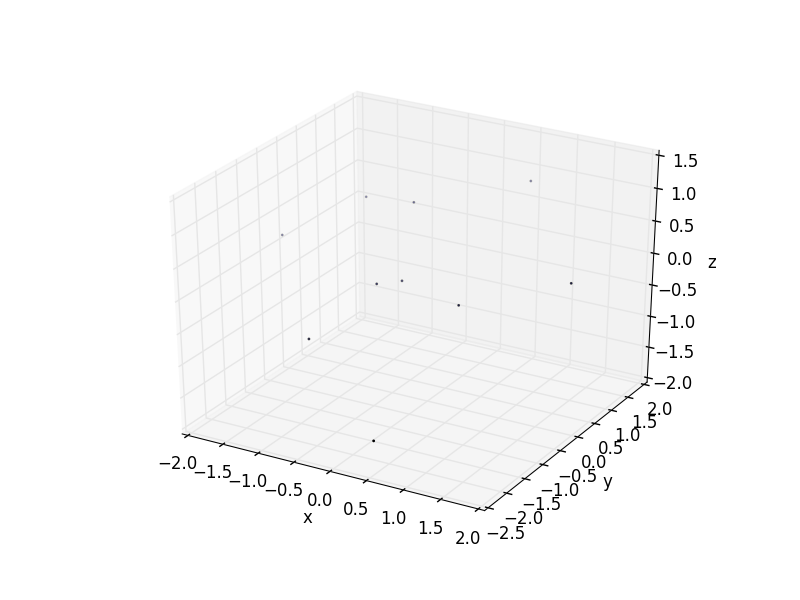

In [12]:
# plot train data, 3d
scatter_3d(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2],ys_train)

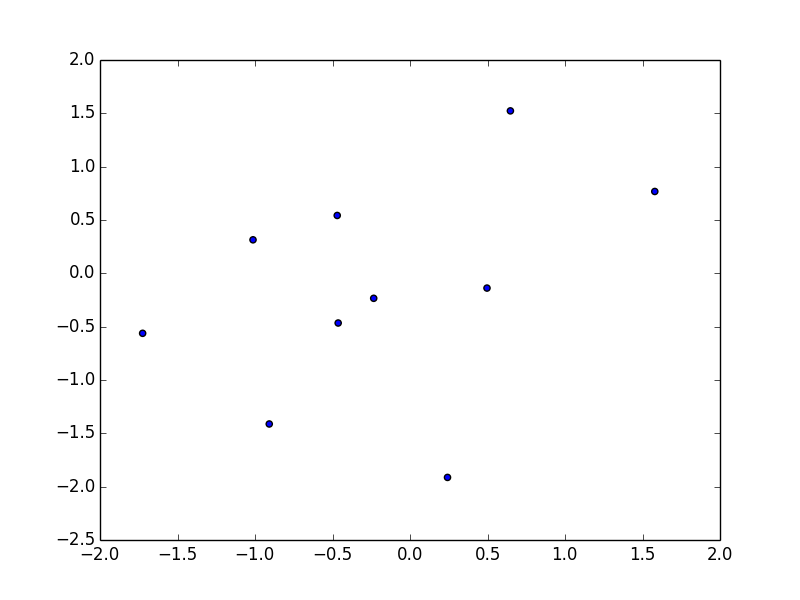

In [13]:
# plot train xs, 2d
scatter(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2])

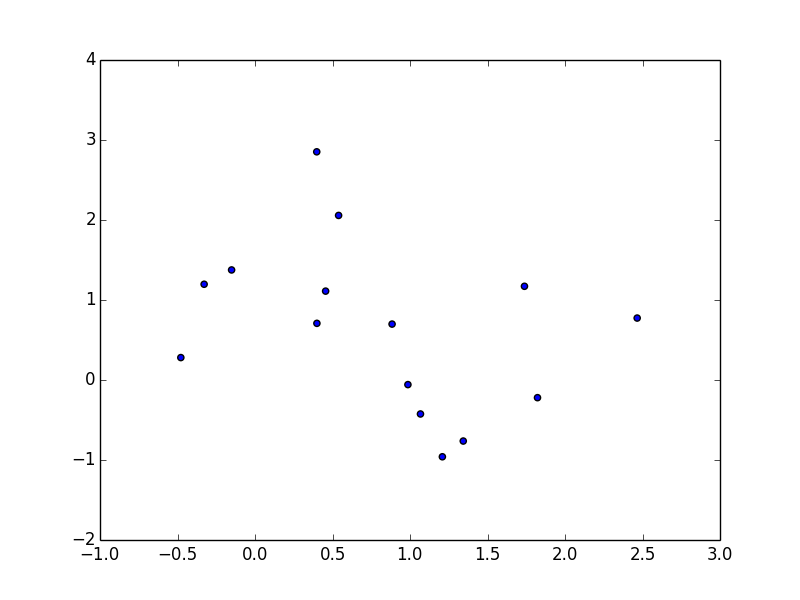

In [14]:
# plot test xs, 2d
scatter(xs_test[:,xs_plot_dim_1],xs_test[:,xs_plot_dim_2])

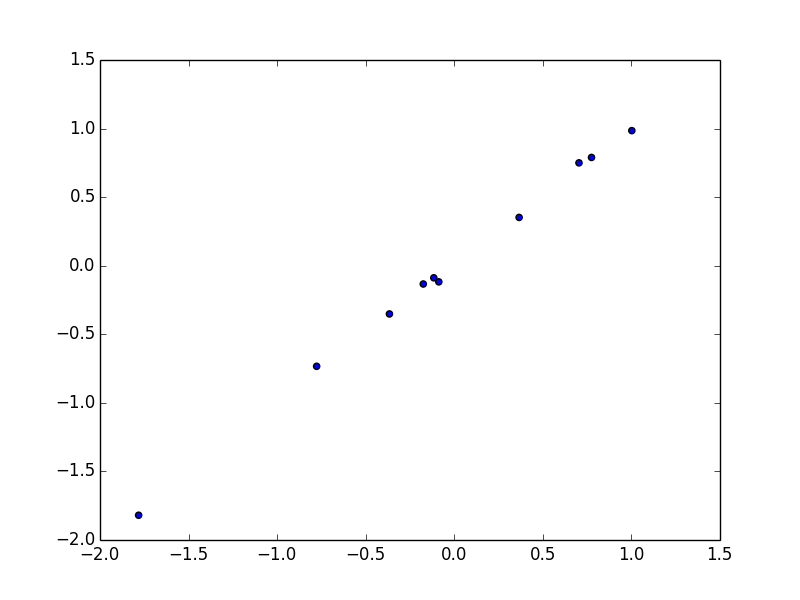

In [15]:
# plot data, 2d
scatter(plot_1d_us_train,ys_train)

In [16]:
# define stuff for SDR
#sigma = 0.1
#sigma = 2.
sigma = 0.5
SDR_get_K = functools.partial(kernels.get_gaussian_K, sigma)
SDR_eps = 0.01
#trace_from_ws_and_Ks = functools.partial(kernels.get_trace_from_ws_and_Ks, SDR_eps)
tradeoff = 1.
trace_from_ws_and_Ks = lambda Ky, Ku, ws: (tradeoff * np.dot(ws.T, ws) / num_train**2) + kernels.get_trace_from_ws_and_Ks(SDR_eps, Ky, Ku, ws) # set ws to None here to turn off weighting of SDR

In [17]:
# define stuff for KMM
B_max = 100
KMM_eps = 0.01
KMM_get_K = SDR_get_K

In [18]:
# define P at which to calculate gradient.  This also induces ws, Ku.  also calculate Ky
#P1 = kernels.ortho(np.random.normal(size=(x_dim,u_dim)))
#P1 = P
P1 = kernels.ortho(np.array([[1,-2.3]]).T)
us_train1 = xs_train.dot(P1)
us_test1 = xs_test.dot(P1)
the_get_KMM_ws = functools.partial(kernels.get_KMM_ws_given_P, xs_train, xs_test, KMM_get_K, B_max, KMM_eps)
ws1 = the_get_KMM_ws(P1)
Ku1 = SDR_get_K(us_train1, us_train1)
Ky = SDR_get_K(ys_train, ys_train)

In [19]:
Ku1

array([[  1.00000000e+00,   1.38061078e-02,   9.20517160e-01,
          7.27346360e-01,   1.30208598e-01,   9.86472934e-01,
          9.47779767e-03,   6.10213860e-01,   1.26427051e-01,
          4.77112383e-01],
       [  1.38061078e-02,   1.00000000e+00,   4.18212088e-02,
          1.03756295e-01,   6.62510349e-01,   2.20764488e-02,
          1.72581880e-08,   1.54476838e-01,   6.71240662e-01,
          1.87247326e-04],
       [  9.20517160e-01,   4.18212088e-02,   1.00000000e+00,
          9.26426178e-01,   2.72629871e-01,   9.71155183e-01,
          2.51887227e-03,   8.41769654e-01,   2.66283581e-01,
          2.67684493e-01],
       [  7.27346360e-01,   1.03756295e-01,   9.26426178e-01,
          1.00000000e+00,   4.74373371e-01,   8.18502521e-01,
          6.03453333e-04,   9.80977337e-01,   4.65972795e-01,
          1.31454929e-01],
       [  1.30208598e-01,   6.62510349e-01,   2.72629871e-01,
          4.74373371e-01,   1.00000000e+00,   1.79248551e-01,
          2.59732238e-06

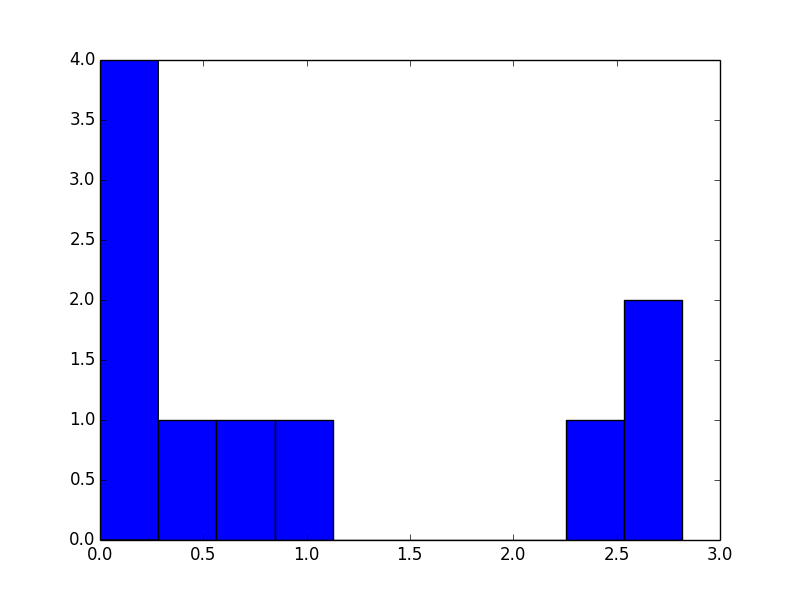

[  4.63739188e-01   2.45981308e+00   1.12119901e-05   1.22170330e-05
   8.90455725e-01   2.22401988e-05   7.04535595e-01   2.56438973e+00
   2.47041489e-05   2.81699683e+00]


In [20]:
# hist of ws1
fig, ax = plt.subplots()
ax.hist(ws1, bins=10)
basic.display_fig_inline(fig)
print ws1

In [21]:
# numerically calculate dL/dP due to change in ws
delta = 0.0001
dL_dP_thru_ws_numeric_val = np.zeros((x_dim, u_dim))
trace1 = trace_from_ws_and_Ks(Ky, Ku1, ws1)
for i in xrange(x_dim):
    for j in xrange(u_dim):
        delta_P_direction = np.zeros((x_dim, u_dim), dtype=float)
        delta_P_direction[i,j] = 1.
        P2 = P1 + (delta * delta_P_direction)
        ws2 = the_get_KMM_ws(P2)
        #print 'ws_prime', ws_prime
        #print 'ws_diff', ws1-ws2
        trace2 = trace_from_ws_and_Ks(Ky, Ku1, ws2)
        #print 'trace_diff', trace2-trace1
        dL_dP_thru_ws_numeric_val[i,j] = (trace2 - trace1) / delta
dL_dP_thru_ws_numeric_val

array([[ 0.66088263],
       [ 0.56849627]])

In [22]:
# general stuff needed to calculate gradient

def f(get_K, B, P):
    
    # create K, kappa, use them to return objective fxn value
    
    import autograd, autograd.numpy as np
    
    us_train = np.dot(xs_train, P)
    us_test = np.dot(xs_test, P)
    K, kappa = kernels.get_KMM_params(us_train, us_test, get_K)
    
    return np.dot(np.dot(B.T, K), B)/2. + np.dot(kappa, B)

the_f = functools.partial(f, KMM_get_K)
df_dws = autograd.jacobian(the_f) # ans dim: |x|
d_dP_df_dws = autograd.jacobian(lambda p,x: df_dws(x,p)) # ans dim: |x| x |p|
d_dws_df_dws = autograd.jacobian(autograd.jacobian(the_f))

A, b = kernels.get_KMM_ineq_constraints(num_train, B_max, KMM_eps)

dtrace_dwsopt = autograd.jacobian(lambda ws, Ky, Ku: trace_from_ws_and_Ks(Ky, Ku, ws))
def get_trace_from_P(trace_from_ws_and_Ks, xs_train, ys_train, SDR_get_K, SDR_eps, P, wsopt):
    us_train = np.dot(xs_train, P)
    #us_test = np.dot(xs_test, P)
    Ku = SDR_get_K(us_train, us_train)
    Ky = SDR_get_K(ys_train, ys_train)
    #Ku, kappau = kernels.get_KMM_params(us_train, us_test, shared_get_K)
    #wsopt = cvxopt_solver(Ku, kappau, A, b)
    return trace_from_ws_and_Ks(Ky, Ku, wsopt)
dtrace_dP_thru_Ku = autograd.jacobian(functools.partial(get_trace_from_P, trace_from_ws_and_Ks, xs_train, ys_train, SDR_get_K, SDR_eps))
#dtrace_dP_thru_Ku = autograd.jacobian(functools.partial(kernels.get_trace_from_P, xs_train, ys_train, SDR_get_K, SDR_eps))

In [23]:
# define some solvers
lstsq_solver = lambda A,b: np.linalg.lstsq(A, b)[0]
reg_lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A,b)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
lin_solver = reg_lstsq_solver
#lin_solver = lstsq_solver
#solver = cg_solver

In [24]:
# calculate gradient (thru wsopt) analytically, slowly
dws_dP_val1 = kernels.get_dxopt_dp(lin_solver, df_dws, d_dP_df_dws, d_dws_df_dws, A, b, ws1, P1)
dtrace_dwsopt_val1 = dtrace_dwsopt(ws1, Ky, Ku1)
np.sum(dws_dP_val1 * dtrace_dwsopt_val1[(slice(None),)+tuple([np.newaxis for i in xrange(len(P1.shape))])], axis=0)

solver error: 0.00578914513549
solver error: 0.000272547281516


array([[ 0.65966745],
       [ 0.56798519]])

In [25]:
# calculate gradient (thru wsopt) analytically efficiently
kernels.get_dL_dp_thru_xopt(lin_solver, df_dws, d_dP_df_dws, d_dws_df_dws, dtrace_dwsopt, A, b, ws1, P1, Ky, Ku1)

solver error: 2.69569917285e-06


array([[ 0.66008113],
       [ 0.56798866]])

In [26]:
print xs_train

[[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]
 [ 1.57921282  0.76743473]
 [-0.46947439  0.54256004]
 [-0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024]
 [-1.72491783 -0.56228753]
 [-1.01283112  0.31424733]
 [-0.90802408 -1.4123037 ]]


In [27]:
# calculate total gradient numerically
delta = 0.0000001
dL_dP_val = np.zeros((x_dim, u_dim))
trace1 = trace_from_ws_and_Ks(Ky, Ku1, ws1)
for i in xrange(x_dim):
    for j in xrange(u_dim):
        delta_P_direction = np.zeros((x_dim, u_dim), dtype=float)
        delta_P_direction[i,j] = 1.
        P2 = P1 + (delta * delta_P_direction)
        ws2 = the_get_KMM_ws(P2)
        us_train2 = np.dot(xs_train, P2)
        Ku2 = SDR_get_K(us_train2, us_train2)
        #print 'K diff', Ku2-Ku1
        #print 'ws_prime', ws_prime
        #print 'ws_diff', ws1-ws2
        trace2 = trace_from_ws_and_Ks(Ky, Ku2, ws2)
        #print 'trace_diff', trace2-trace1
        dL_dP_val[i,j] = (trace2 - trace1) / delta
dL_dP_val

array([[-39.49069159],
       [-14.15163683]])

In [28]:
# calculate total gradient analytically
#the_raw_get_KMM_ws = functools.partial(kernels.get_KMM_ws, B_max, KMM_eps)
kernels.get_dobj_dP(xs_train, xs_test, Ky, SDR_get_K, SDR_get_K, dtrace_dP_thru_Ku, lin_solver, kernels.cvxopt_solver, df_dws, d_dP_df_dws, d_dws_df_dws, dtrace_dwsopt, A, b, P1)

solver error: 4.84785995888e-06


array([[-39.49071866],
       [-14.15164882]])

In [29]:
# now, calculate same gradient analytically

# first, get dL/dws to calculate the gradient at ws1
dL_dwopt = autograd.jacobian(lambda ws, Ky, Ku: trace_from_ws_and_Ks(Ky, Ku, ws))
dL_dw_anal_val1 = dtrace_dwsopt(ws1, Ky, Ku1)
print 'asdf',dL_dw_anal_val1

# get tight constraints
A_tight, b_tight = kernels.get_tight_constraints(A, b, ws1)
num_tight = A_tight.shape[0]

# make C matrix
C = np.vstack((np.hstack((Ku1,-A_tight.T)), np.hstack((A_tight,np.zeros((num_tight,num_tight))))))

# make d vector
d = np.hstack((dL_dw_anal_val1, np.zeros(num_tight)))

# solve Cx=d for x
x, cg_info = scipy.sparse.linalg.cg(C, d)
ans = np.linalg.lstsq(C, d)
x = ans[0]
#print 'cg_info:', cg_info
#print C.shape
print np.linalg.norm(np.dot(C,x) - d)
# make D
#the_f = functools.partial(f, KMM_get_K)
df_dB = autograd.jacobian(the_f) # ans dim: |B|
d_dP_df_dB = autograd.jacobian(lambda P,B: df_dB(B,P)) # ans dim: |B| x |P|
d_dP_df_dB_anal_val1 = -d_dP_df_dB(P1, ws1)
D = np.vstack((d_dP_df_dB_anal_val1, np.zeros((num_tight, x_dim, u_dim))))
print D.shape, num_tight
#print D.T * x[np.newaxis, np.newaxis,:]
np.sum(D.T * x[tuple([np.newaxis for i in xrange(len(P.shape))])+(slice(None),)], axis=-1).T
#D = np.vstack(d_dP_df_dB(P1, B_P1), np.zeros(num)

asdf [  9.27478375e-03   4.91962615e-02   2.24130662e-07   2.44719010e-07
   1.78091145e-02   4.44916754e-07   1.40907119e-02   5.12877946e-02
   4.94066607e-07   5.63399366e-02]
1.96087084039e-16
(15, 2, 1) 5


array([[ 0.66009024],
       [ 0.56799261]])

In [30]:
assert False

AssertionError: 